In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
import numpy as np
from sindy_utils import *
from training_LaSDI import train_autoencoder, train_DI
from autoencoder_LaSDI import AE_network

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()

from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle 
import copy
import subprocess as sp
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 10934
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 13700
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='2'))

# Load data

In [4]:
# load training data
scaled_AE = 1 # 1: normalize data to [0,1] (for physical variables)
scaled_DI = 1 # 1: normalize data to [0,1] (for latent variables)

p1_train = np.linspace(1.5, 1.8, 5)
p2_train = np.linspace(2, 2.3, 5)
num_train = p1_train.size * p2_train.size  # number of training cases
tstop = 3
dt = 1e-2

if num_train > 1:
    train_data = pickle.load(open(f"./data/local{num_train}_tstop{tstop:.1f}b.p", "rb"))
else:
    train_data = pickle.load(open(f"./data/local{num_train}_p1{p1_train[0]:.1f}_p2{p2_train[0]:.1f}_tstop{tstop:.1f}.p", "rb"))
num_DI = len(train_data['data'])
input_dim = train_data['data'][0]['x'].shape[1]
nt = train_data['data'][0]['x'].shape[0]

for i in range(num_DI):
    print(f"train case {i}: params: {train_data['param'][i]}, x shape: {train_data['data'][i]['x'].shape}")

train case 0: params: [1.5 2. ], x shape: (301, 9216)
train case 1: params: [1.5 2.5], x shape: (301, 9216)
train case 2: params: [2. 2.], x shape: (301, 9216)
train case 3: params: [2.  2.5], x shape: (301, 9216)


In [5]:
train_data_AE = []
for i in range(num_train):
    train_data_AE.append(train_data['data'][i]['x'])
train_data_AE = np.vstack(train_data_AE)
train_data_x = deepcopy(train_data_AE)
print(train_data_AE.shape)

(1204, 9216)


# Set up model and training parameters

In [6]:
params_AE = {}

params_AE['seed'] = 1 # random seed
params_AE['config'] = config
params_AE['input_dim'] = input_dim
params_AE['latent_dim'] = 3
params_AE['activation'] = 'sigmoid'
params_AE['widths'] = [100]

# training parameters
params_AE['epoch_size_AE'] = train_data_AE.shape[0]
params_AE['batch_size'] = 100
params_AE['learning_rate'] = 5e-6
params_AE['fig_path'] = os.getcwd() + '/fig/nCase25b_ld3_p1_width100_lr5e-6_1e-4_scaledAE_scaledDI/'
params_AE['print_frequency'] = 100

# training time cutoffs
params_AE['max_epochs_AE'] = 80000  # max number of training epochs       

# PDE parameters
params_AE['pde'] = {}
params_AE['pde']['tstop'] = tstop

# normalization
params_AE['scaled'] = scaled_AE # if data is normalized

In [7]:
params_DI = {}

params_DI['seed'] = 1 # random seed
params_DI['config'] = config
params_DI['num_DI'] = num_DI
params_DI['param'] = train_data['param']
params_DI['latent_dim'] = params_AE['latent_dim']
params_DI['model_order'] = 1
params_DI['poly_order'] = 1
params_DI['include_sine'] = False
params_DI['include_cosine'] = False
params_DI['include_costant'] = True
params_DI['library_dim'] = library_size(params_DI['latent_dim'], params_DI['poly_order'], 
                                     params_DI['include_sine'], params_DI['include_cosine'], 
                                     params_DI['include_costant'])

# sequential thresholding parameters
params_DI['sequential_thresholding'] = False
params_DI['coefficient_threshold'] = 0.1
params_DI['threshold_frequency'] = 500
params_DI['coefficient_mask'] = np.ones((params_DI['library_dim'], params_DI['latent_dim']))
params_DI['coefficient_initialization'] = 'constant'

# training parameters
params_DI['epoch_size_DI'] = train_data['data'][0]['x'].shape[0]
params_DI['batch_size'] = train_data['data'][0]['x'].shape[0]
params_DI['learning_rate'] = 1e-4
params_DI['fig_path'] = params_AE['fig_path']
params_DI['print_frequency'] = 100

# training time cutoffs
params_DI['max_epochs_DI'] = 100000  # max number of training epochs        

# PDE parameters
params_DI['pde'] = {}
params_DI['pde']['tstop'] = tstop

# normalization
params_DI['scaled'] = scaled_DI # if data is normalized

# Train Autoencoder

In [8]:
if scaled_AE:
    print(f'before scaling: min: {train_data_AE.min()}, ma: {train_data_AE.max()}')
    x_min = train_data_AE.min()
    train_data_AE -= x_min
    x_max = train_data_AE.max()
    train_data_AE /= x_max
    print(f'after scaling: min: {train_data_AE.min()}, ma: {train_data_AE.max()}')
    params_AE['x_min'] = x_min
    params_AE['x_max'] = x_max

In [9]:
df = pd.DataFrame()
timer = []
timer.append(time())

params_AE['save_name'] = 'ex16_AE_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    
tf.reset_default_graph()
results_dict,x_decode,z = train_autoencoder(train_data_AE, params_AE)
df = df.append({**results_dict}, ignore_index=True)

timer.append(time())
print(f'training time: {(timer[-1]-timer[0])/60:.2f} mins')
if scaled_AE:
    x_decode = x_decode * x_max + x_min
    
err_decoder = np.linalg.norm(train_data_x - x_decode, axis=1) / np.linalg.norm(train_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')

Epoch 0, loss: 2.6570e-01
Epoch 100, loss: 7.5185e-03
Epoch 200, loss: 3.6814e-03
Epoch 300, loss: 3.0503e-03
Epoch 400, loss: 2.9418e-03
Epoch 500, loss: 2.8610e-03
Epoch 600, loss: 2.7659e-03
Epoch 700, loss: 2.5837e-03
Epoch 800, loss: 2.3583e-03
Epoch 900, loss: 2.2368e-03
Epoch 1000, loss: 1.9785e-03
Epoch 1100, loss: 1.8708e-03
Epoch 1200, loss: 1.5193e-03
Epoch 1300, loss: 1.0030e-03
Epoch 1400, loss: 5.9326e-04
Epoch 1500, loss: 3.1878e-04
Epoch 1600, loss: 1.7948e-04
Epoch 1700, loss: 3.1942e-04
Epoch 1800, loss: 7.3203e-05
Epoch 1900, loss: 8.9116e-05
Epoch 2000, loss: 7.2978e-05
Epoch 2100, loss: 7.9485e-05
Epoch 2200, loss: 4.3467e-05
Epoch 2300, loss: 2.7206e-05
Epoch 2400, loss: 6.5051e-05
Epoch 2500, loss: 2.3170e-05
Epoch 2600, loss: 6.0147e-05
Epoch 2700, loss: 1.5977e-05
Epoch 2800, loss: 4.5221e-05
Epoch 2900, loss: 1.4569e-05
Epoch 3000, loss: 1.1149e-05
Epoch 3100, loss: 1.0494e-05
Epoch 3200, loss: 1.8043e-05
Epoch 3300, loss: 5.0508e-05
Epoch 3400, loss: 1.0036e-

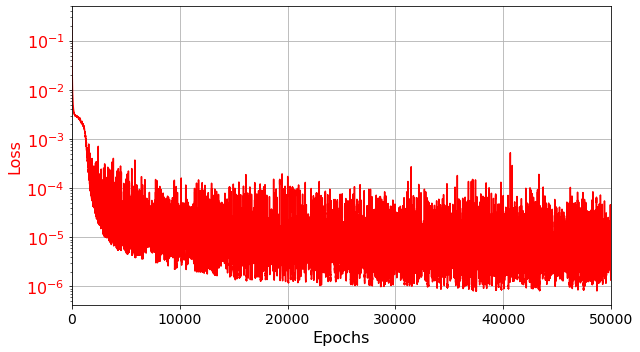

In [10]:
# loss history
train_loss = np.array(results_dict['train_losses_AE']).squeeze()
# test_loss = np.array(results_df['testing_losses'][0]).squeeze()

fig, ax1 = plt.subplots(figsize=(9,5))
xt = np.linspace(1,results_dict['max_epochs_AE'],train_loss.size)
ax1.plot(xt, train_loss, 'r', label='Train')
ax1.set_yscale('log')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', color='r', fontsize=16)
ax1.set_xlim(0, results_dict['max_epochs_AE'])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='y', labelcolor='r')
plt.grid()
plt.tight_layout()
plt.savefig(params_AE['fig_path'] + f"/loss_AE.png")

# Train Dynamics Identification Models

In [11]:
def derivative(X):
    dXdt = np.empty(X.shape)
    D = D_Lele(X.shape[0], tstop/X.shape[0])   
    for i in range(X.shape[1]):
        dXdt[:,i] = np.dot(D.toarray(), X[:,i])
    del D
    return dXdt

In [12]:
# normalize z
if scaled_DI:
    print(f'before scaling: min: {z.min()}, ma: {z.max()}')
    z_min = z.min()
    z -= z_min
    z_max = z.max()
    z /= z_max
    print(f'after scaling: min: {z.min()}, ma: {z.max()}')
    params_DI['z_min'] = z_min
    params_DI['z_max'] = z_max

# calculate dz/dt
for i in range(num_train):
    z_tmp = z[i*nt:(i+1)*nt,:]
    dzdt = derivative(z_tmp)
    train_data['data'][i]['z'] = z_tmp
    train_data['data'][i]['dz'] = dzdt
    
print(train_data['data'][0]['z'].shape, train_data['data'][0]['dz'].shape)

(301, 3) (301, 3)


In [13]:
df = pd.DataFrame()
timer = []
timer.append(time())

params_DI['save_name'] = 'ex16_DI_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    
tf.reset_default_graph()
results_dict = train_DI(train_data, params_DI)
df = df.append({**results_dict}, ignore_index=True)

timer.append(time())
print(f'training time: {(timer[-1]-timer[0])/60:.2f} mins')

Epoch 0, loss: 1.4003e+05
Epoch 100, loss: 9.3522e+04
Epoch 200, loss: 6.0734e+04
Epoch 300, loss: 3.8498e+04
Epoch 400, loss: 2.3943e+04
Epoch 500, loss: 1.4697e+04
Epoch 600, loss: 8.9600e+03
Epoch 700, loss: 5.4624e+03
Epoch 800, loss: 3.3564e+03
Epoch 900, loss: 2.0951e+03
Epoch 1000, loss: 1.3349e+03
Epoch 1100, loss: 8.6735e+02
Epoch 1200, loss: 5.7089e+02
Epoch 1300, loss: 3.7737e+02
Epoch 1400, loss: 2.4905e+02
Epoch 1500, loss: 1.6424e+02
Epoch 1600, loss: 1.0923e+02
Epoch 1700, loss: 7.4534e+01
Epoch 1800, loss: 5.3234e+01
Epoch 1900, loss: 4.0355e+01
Epoch 2000, loss: 3.2485e+01
Epoch 2100, loss: 2.7440e+01
Epoch 2200, loss: 2.3933e+01
Epoch 2300, loss: 2.1275e+01
Epoch 2400, loss: 1.9128e+01
Epoch 2500, loss: 1.7341e+01
Epoch 2600, loss: 1.5843e+01
Epoch 2700, loss: 1.4596e+01
Epoch 2800, loss: 1.3570e+01
Epoch 2900, loss: 1.2736e+01
Epoch 3000, loss: 1.2065e+01
Epoch 3100, loss: 1.1526e+01
Epoch 3200, loss: 1.1095e+01
Epoch 3300, loss: 1.0746e+01
Epoch 3400, loss: 1.0459e+

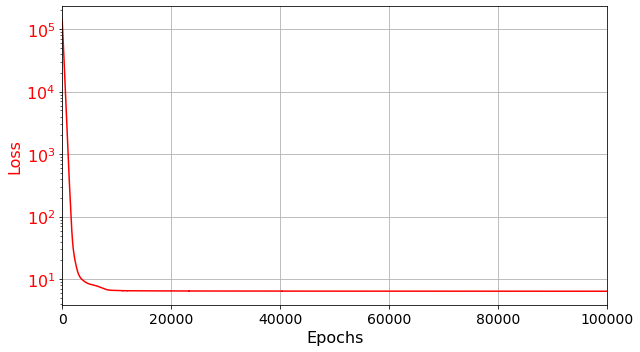

In [14]:
# loss history
train_loss = np.array(results_dict['train_losses_DI']).squeeze()
# test_loss = np.array(results_df['testing_losses'][0]).squeeze()

fig, ax1 = plt.subplots(figsize=(9,5))
xt = np.linspace(1,results_dict['max_epochs_DI'],train_loss.size)
ax1.plot(xt, train_loss, 'r', label='Train')
ax1.set_yscale('log')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', color='r', fontsize=16)
ax1.set_xlim(0, results_dict['max_epochs_DI'])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='y', labelcolor='r')
plt.grid()
plt.tight_layout()
plt.savefig(params_DI['fig_path'] + f"/loss_DI.png")